In [1]:
%matplotlib inline

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os, sys, json

sns.set_palette("muted")
sns.set_context("talk")
sns.set_style("white")
pd.set_option("display.max_columns", None)

plt.rcParams['font.family']='NanumGothic'
plt.rcParams['axes.unicode_minus'] = False

In /opt/conda/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The text.latex.preview rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In /opt/conda/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The mathtext.fallback_to_cm rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In /opt/conda/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: Support for setting the 'mathtext.fallback_to_cm' rcParam is deprecated since 3.3 and will be removed two minor releases later; use 'mathtext.fallback : 'cm' instead.
In /opt/conda/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The validate_bool_maybe_none function was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In /opt/conda/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The savefig.

### create rectangle

In [2]:
import geopandas as gpd
from shapely.geometry import MultiPoint

def create_rec(x, y, width, length, angle):
    l_half = length/2
    w_half = width/2
    a_rad = np.deg2rad(angle)
    
    def get_coord(l_half, w_half, a_rad):
        X = x + l_half * np.sin(a_rad) - w_half * np.cos(a_rad)
        Y = y + l_half * np.cos(a_rad) + w_half * np.sin(a_rad)
        return (X, Y)
    
    points = [get_coord(l_half, w_half, a_rad),
              get_coord(-l_half, w_half, a_rad),
              get_coord(-l_half, -w_half, a_rad),
              get_coord(l_half, -w_half, a_rad)
             ]
    
    rec = gpd.GeoDataFrame({"points":[points], "geometry":[MultiPoint(points).convex_hull]})
    return rec

In [3]:
rec = create_rec(0, 0, 4, 6, 45)
rec

,points,geometry
0,"[(0.7071067811865472, 3.5355339059327378), (-3...","POLYGON ((-0.70711 -3.53553, -3.53553 -0.70711..."


<AxesSubplot:>

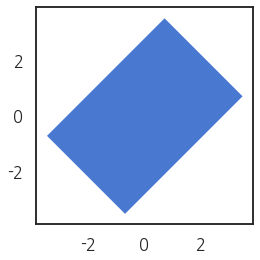

In [4]:
rec.plot()

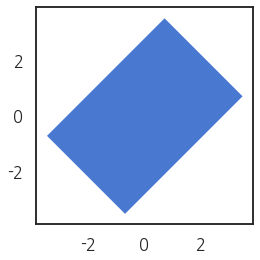

In [5]:
fig, ax = plt.subplots()
rec.plot(ax=ax)
fig.savefig("5_shadow_2.png")

### diurnal motion of the sun

In [6]:
import datetime
from pysolar.solar import get_altitude, get_azimuth

# Daejeon
lats = list(range(0, 100, 10))
lon = 127.3845

# Spring equinox
KST = datetime.timezone(datetime.timedelta(hours=9))
date = datetime.datetime(2017, 3, 21, 13, 0, 0, tzinfo=KST)

# data
nlats = len(lats)
alts_lat = {}
azis_lat = {}
date_hr_lat = {}

# altitudes and azimuthal angles
for i, lat in enumerate(lats):
    alts, azis, dates_hr = [], [], []
    for hh in range(24):
        for mm in range(0, 60, 1):
            date_hr = datetime.datetime(2017, 3, 21, hh, mm, 0, tzinfo=KST)
            dates_hr.append(date_hr)
            alt = get_altitude(lat, lon, date_hr)
            azi = get_azimuth(lat, lon, date_hr)
            alts.append(alt)
            azis.append(azi)

    date_hr_lat[i] = dates_hr
    alts = np.array(alts)      
    alts_lat[i] = alts
    azis = np.array(azis)
    azis_lat[i] = azis

hhmm = list(range(1440))    

In [7]:
df_azialt = {}
select_values = np.linspace(90, 270+11.25, 18)
azis_arcgis = {}
alts_arcgis = {}

for i, lat in enumerate(lats):
    df_azialt[i] = pd.DataFrame({"date_hr":hhmm, "azimuth":azis_lat[i], "altitude":alts_lat[i]})
    pcut = pd.cut(df_azialt[i]["azimuth"], select_values)
    azis_arcgis[i] = df_azialt[i]["azimuth"].groupby(pcut).nth(0).values
    alts_arcgis[i] = df_azialt[i]["altitude"].groupby(pcut).nth(0).values

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:19: UserWarning: FixedFormatter should only be used together with FixedLocator
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:42: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


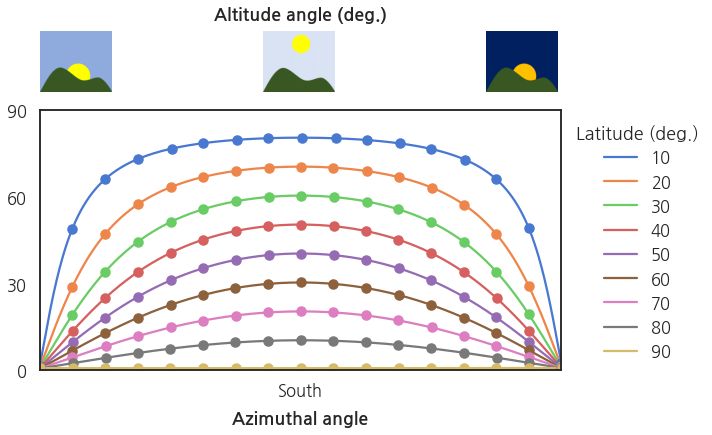

In [8]:
from matplotlib.ticker import MultipleLocator

fig, ax = plt.subplots(figsize=(10, 10))
lines = []

for i in range(1, nlats):
    line = ax.plot(azis_lat[i], alts_lat[i], zorder=1)
    lines.append(line)
    ax.scatter(azis_arcgis[i], alts_arcgis[i], zorder=1.1)
    
ax.set_aspect("equal")
ax.set_xlim(90, 270)  
ax.set_ylim(0, 90)

xticklabels = [""]*len(ax.get_xticks())
xticklabels[0] = "East"
xticklabels[int(len(ax.get_xticks())/2)] = "South"
xticklabels[-1] = "West"
ax.set_xticklabels(xticklabels)
ax.set_xlabel("Azimuthal angle", fontdict={"fontweight":"bold"}, labelpad=12)
ax.set_title("Altitude angle (deg.)", fontdict={"fontweight":"bold"}, pad=90)
ax.yaxis.set_major_locator(MultipleLocator(30))

plt.legend(lats[1:], bbox_to_anchor=(1,1), frameon=False, title="Latitude (deg.)")

im_sunrise = plt.imread("sunrise.png")
ax_sunrise = fig.add_axes([0.06, 0.69, 0.1, 0.1], anchor="NW", zorder=2)
ax_sunrise.imshow(im_sunrise)
ax_sunrise.axis("off")

im_suntop = plt.imread("suntop.png")
ax_suntop = fig.add_axes([0.37, 0.69, 0.1, 0.1], anchor="NW", zorder=2)
ax_suntop.imshow(im_suntop)
ax_suntop.axis("off")


im_sunset = plt.imread("sunset.png")
ax_sunset = fig.add_axes([0.68, 0.69, 0.1, 0.1], anchor="NW", zorder=2)
ax_sunset.imshow(im_sunset)
ax_sunset.axis("off")

fig.tight_layout()
fig.savefig("5_shadow_3.png")

### create shadow @Daejeon

In [9]:
# Daejeon
lat = 36.3504
lon = 127.3845

alts, azis = [], []
for hr in range(24):
    for minu in range(0, 60, 1):
        date_hr = datetime.datetime(2017, 3, 21, hr, minu, 0, tzinfo=KST)
        alt = get_altitude(lat, lon, date_hr)
        azi = get_azimuth(lat, lon, date_hr)
        alts.append(alt)
        azis.append(azi)

alts = np.array(alts)        
azis = np.array(azis)

In [10]:
# for ArcGIS

df_solar = pd.DataFrame({"hh":np.array(range(1440))//60,
                         "mm":np.array(range(1440))%60,
                         "azimuth": azis,
                         "altitude": alts,
                         "projection": np.sin(np.deg2rad(alts))
                        })
df_solar["shadow_len"] = df_solar["altitude"].apply(lambda x: 1/np.tan(np.deg2rad(x)) if x > 0 else np.nan)
df_solar["shadow_dx"] = -df_solar["shadow_len"] * np.sin(np.deg2rad(df_solar["azimuth"]))
df_solar["shadow_dy"] = -df_solar["shadow_len"] * np.cos(np.deg2rad(df_solar["azimuth"]))

select_values = np.linspace(90, 270+11.25, 18)
pcut = pd.cut(df_solar["azimuth"], select_values)
index_arcgis = [df_solar[df_solar["azimuth"] == v].index[0] for v in df_solar["azimuth"].groupby(pcut).nth(0).values]
index_arcgis

df_arcgis = df_solar.loc[index_arcgis].reset_index(drop=True)
df_arcgis.head()

,hh,mm,azimuth,altitude,projection,shadow_len,shadow_dx,shadow_dy
0,6,39,90.044913,0.795445,0.013883,72.025176,-72.025154,0.056458
1,7,53,101.259604,15.249525,0.263023,3.668077,-3.597476,0.716209
2,8,59,112.604453,27.939116,0.468533,1.885557,-1.740710,0.724746
3,9,53,123.934569,37.520979,0.609052,1.302238,-1.080435,0.726969
4,10,36,135.082092,44.214755,0.697350,1.027793,-0.725717,0.727800


In [11]:
def get_shadows_1(src_x, src_y, src_width, src_length, src_height, src_angle, df_arcgis):
    # shadow points
    s_points = []
    rec = create_rec(src_x, src_y, src_width, src_length, src_angle)
    points = rec.loc[0, "points"]
    
    for px, py in points:
        sx = px + src_height * df_arcgis["shadow_dx"].values
        sy = py + src_height * df_arcgis["shadow_dy"].values
        s_points.append(list(zip(sx, sy)))
    
    shadows_list = []
    for i in range(df_arcgis.shape[0]):
        mpoints_i = MultiPoint(points + np.array(s_points)[:,i].tolist())
        shadows_list.append(mpoints_i)
    
    shadows = gpd.GeoDataFrame({"geometry":shadows_list})
    return shadows

In [12]:
shadows_1 = get_shadows_1(0, 0, 4, 6, 8, 45, df_arcgis)
shadows_1.head()

,geometry
0,"MULTIPOINT (0.707 3.536, -3.536 -0.707, -0.707..."
1,"MULTIPOINT (0.707 3.536, -3.536 -0.707, -0.707..."
2,"MULTIPOINT (0.707 3.536, -3.536 -0.707, -0.707..."
3,"MULTIPOINT (0.707 3.536, -3.536 -0.707, -0.707..."
4,"MULTIPOINT (0.707 3.536, -3.536 -0.707, -0.707..."


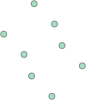

In [13]:
shadows_1.loc[5, "geometry"]

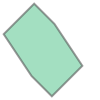

In [14]:
shadows_1.loc[5, "geometry"].convex_hull

In [15]:
def get_shadows_2(src_x, src_y, src_width, src_length, src_height, src_angle, df_arcgis):
    # shadow points
    s_points = []
    rec = create_rec(src_x, src_y, src_width, src_length, src_angle)
    points = rec.loc[0, "points"]
    
    for px, py in points:
        sx = px + src_height * df_arcgis["shadow_dx"].values
        sy = py + src_height * df_arcgis["shadow_dy"].values
        s_points.append(list(zip(sx, sy)))
    
    shadows_list = []
    for i in range(df_arcgis.shape[0]):
        mpoints_i = MultiPoint(points + np.array(s_points)[:,i].tolist())
        shadows_list.append(mpoints_i.convex_hull)
    
    shadows = gpd.GeoDataFrame({"geometry":shadows_list})
    return shadows

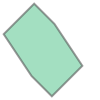

In [16]:
shadows_2 = get_shadows_2(0, 0, 4, 6, 8, 45, df_arcgis)
shadows_2.loc[5, "geometry"]

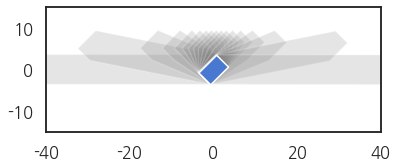

In [17]:
fig, ax = plt.subplots()
shadows_2.plot(ax=ax, facecolor="gray", edgecolor="w", alpha=0.2)
rec.plot(ax=ax)
ax.set_xlim(-40, 40)
ax.set_ylim(-15, 15)
fig.savefig("5_shadow_8.png")

### create shadow on target building rooftop @Daejeon

In [18]:
tgt = create_rec(5, 5, 3, 3, 15)
tgt

,points,geometry
0,"[(3.939339828220179, 6.837117307087384), (3.16...","POLYGON ((6.06066 3.16288, 3.16288 3.93934, 3...."


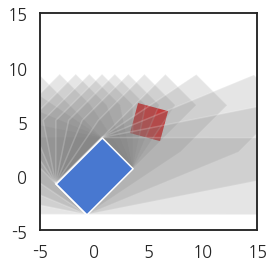

In [19]:
fig, ax = plt.subplots()
shadows_2.plot(ax=ax, facecolor="gray", edgecolor="w", alpha=0.2, zorder=1)
rec.plot(ax=ax)
tgt.plot(ax=ax, facecolor="red", zorder=0.9)
ax.set_xlim(-5, 15)
ax.set_ylim(-5, 15)
fig.savefig("5_shadow_9.png")

<AxesSubplot:>

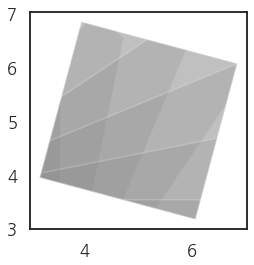

In [20]:
intersections = []
for i in range(shadows_2.shape[0]):
    intersection = shadows_2.loc[i, "geometry"].intersection(tgt.loc[0, "geometry"])
    intersections.append(intersection)
    
shadows_on_target = gpd.GeoDataFrame({"geometry":intersections})
shadows_on_target["area"] = shadows_on_target["geometry"].area
shadows_on_target.query("area > 0").plot(facecolor="gray", alpha=0.2)    

In [21]:
shadows_on_target["shadow_portion"] = shadows_on_target["area"]/(3*3) * df_arcgis["projection"]
tgt_loss_ratio = shadows_on_target["shadow_portion"].sum()/df_arcgis["projection"].sum()
display(shadows_on_target)
print(f"loss ratio on target = {tgt_loss_ratio:0.2f}")

,geometry,area,shadow_portion
0,POLYGON EMPTY,0.000000,0.000000
1,POLYGON EMPTY,0.000000,0.000000
2,POLYGON EMPTY,0.000000,0.000000
3,POLYGON EMPTY,0.000000,0.000000
4,POLYGON EMPTY,0.000000,0.000000
5,POLYGON EMPTY,0.000000,0.000000
6,POLYGON EMPTY,0.000000,0.000000
7,POLYGON EMPTY,0.000000,0.000000
8,"POLYGON ((3.54858 5.37879, 3.54428 3.83715, 3....",0.294208,0.026427
9,"POLYGON ((4.58986 6.66281, 4.72305 6.52962, 4....",2.758285,0.246029


loss ratio on target = 0.32


### Comparison with Paper

<AxesSubplot:>

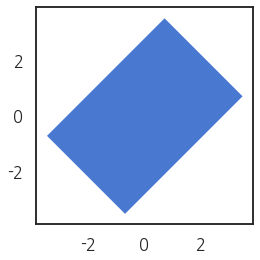

In [22]:
# source building

src_width = 4
src_length = 6
src_tall = 8
src_angle = 45

src_rec = create_rec(0, 0, src_width, src_length, src_angle)
src_rec.plot()

In [295]:
# cities and latitudes
cities = ["Philadelphia", "Adderly", "Agua Blanca", "Antofagasta", "Los Lagos"]
lats = [39+57/60, 23+36/60, -2/60, -(23+39/60), -(39+51/60)]
lons = [-(75+9/60), -(75+18/60), -(75+12/60), -(72+0/60), -(72+50/60)]  # negative for East Longitude
TZs = [-5, -5, -5, -5, -5]

In [296]:
### data
nlats = len(lats)
alts_lat = {}
azis_lat = {}
date_hr_lat = {}

### altitudes and azimuthal angles
for i, (lat, lon, TZ) in enumerate(zip(lats, lons, TZs)):
    # timezone
    tz = datetime.timezone(datetime.timedelta(hours=TZ))
    
    alts, azis, dates_hr = [], [], []
    for hh in range(24):
        for mm in range(0, 60, 30):
            date_hr = datetime.datetime(2008, 3, 21, hh, mm, 0, tzinfo=tz)
            dates_hr.append(date_hr)
            alt = get_altitude(lat, lon, date_hr)
            azi = get_azimuth(lat, lon, date_hr)
            alts.append(alt)
            azis.append(azi)

    date_hr_lat[i] = dates_hr
    alts = np.array(alts)      
    alts_lat[i] = alts
    azis = np.array(azis)
    azis_lat[i] = azis

In [306]:
# df_azialt = {}
# azis_arcgis = {}
# alts_arcgis = {}
df_solars = {}

for i, lat in enumerate(lats):
#     df_azialt[i] = pd.DataFrame({"azimuth":azis_lat[i], "altitude":alts_lat[i]})
#     pcut = pd.cut(df_azialt[i]["azimuth"], select_values)
#     azis_arcgis[i] = df_azialt[i]["azimuth"].groupby(pcut).nth(0).values
#     alts_arcgis[i] = df_azialt[i]["altitude"].groupby(pcut).nth(0).values
    
    df_solar = pd.DataFrame({"hh":[date_hr_lat[i][j].strftime("%H") for j in range(48)],
                             "mm":[date_hr_lat[i][j].strftime("%M") for j in range(48)],
                             "azimuth": azis_lat[i],
                             "altitude": alts_lat[i],
                             "projection": np.sin(np.deg2rad(alts_lat[i]))
                            })
    df_solar["shadow_len"] = df_solar["altitude"].apply(lambda x: 1/np.tan(np.deg2rad(x)) if x > 0 else np.nan)
    df_solar["shadow_dx"] = -df_solar["shadow_len"] * np.sin(np.deg2rad(df_solar["azimuth"]))
    df_solar["shadow_dy"] = -df_solar["shadow_len"] * np.cos(np.deg2rad(df_solar["azimuth"]))
    
    df_solars[i] = df_solar

In [326]:
df_solars[0].loc[10:15]

,hh,mm,azimuth,altitude,projection,shadow_len,shadow_dx,shadow_dy
10,05,00,78.582958,-12.595784,-0.218071,NaN,NaN,NaN
11,05,30,83.551119,-6.911019,-0.120328,NaN,NaN,NaN
12,06,00,88.394286,-1.170862,-0.020434,NaN,NaN,NaN
13,06,30,93.211325,4.752352,0.082849,12.028639,-12.009750,0.673831
14,07,00,98.100075,10.395721,0.180446,5.450864,-5.396484,0.768041
15,07,30,103.162453,16.022081,0.276008,3.482349,-3.390862,0.792975


In [323]:
shadows_test1 = get_shadows_1(0, 0, 4, 6, 8, 45, df_solars[0])
shadows_test1.head()

,geometry
0,"MULTIPOINT (0.70711 3.53553, -3.53553 -0.70711..."
1,"MULTIPOINT (0.70711 3.53553, -3.53553 -0.70711..."
2,"MULTIPOINT (0.70711 3.53553, -3.53553 -0.70711..."
3,"MULTIPOINT (0.70711 3.53553, -3.53553 -0.70711..."
4,"MULTIPOINT (0.70711 3.53553, -3.53553 -0.70711..."


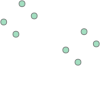

In [330]:
shadows_test1.loc[17, "geometry"]

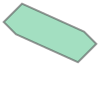

In [331]:
shadows_test1.loc[17, "geometry"].convex_hull

In [307]:
for i in range(5):
    display(df_solars[i].loc[df_solars[i]["hh"] == "09"].loc[df_solars[3]["mm"] == "30"])

,hh,mm,azimuth,altitude,projection,shadow_len,shadow_dx,shadow_dy
19,09,30,127.594582,36.764854,0.598532,1.338438,-1.060508,0.816541


,hh,mm,azimuth,altitude,projection,shadow_len,shadow_dx,shadow_dy
19,09,30,115.221423,45.261467,0.710326,0.990914,-0.896448,0.422246


,hh,mm,azimuth,altitude,projection,shadow_len,shadow_dx,shadow_dy
19,09,30,89.113383,50.542738,0.772099,0.823084,-0.822986,-0.012736


,hh,mm,azimuth,altitude,projection,shadow_len,shadow_dx,shadow_dy
19,09,30,60.693767,47.301142,0.734928,0.922737,-0.804641,-0.451659


,hh,mm,azimuth,altitude,projection,shadow_len,shadow_dx,shadow_dy
19,09,30,49.329653,37.341543,0.606565,1.310715,-0.99414,-0.854201


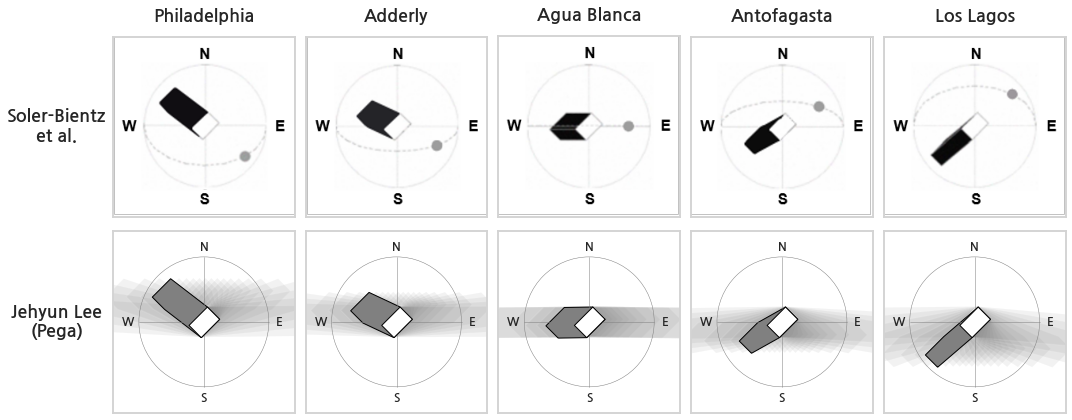

In [309]:
from matplotlib.patches import Circle

fig, axes = plt.subplots(ncols=5, nrows=2, figsize=(15, 6))
axs = axes.ravel()

for i in range(5):
    paper_im = plt.imread(f"paper_{i}.png")
    axs[i].imshow(paper_im)
    axs[i].set_xticks([])
    axs[i].set_yticks([])
    [axs[i].spines[k].set_edgecolor("lightgray") for k in axs[i].spines.keys()]
    
    axs[i].set_title(cities[i], fontdict={"fontweight":"bold"}, pad=16)
    
    if i == 0:
        axs[i].set_ylabel("Soler-Bientz\net al.", rotation=0, labelpad=56, 
                          fontdict={"fontweight":"bold", "ha":"center", "va":"center"})

for i in range(5, 10):
    shadow = get_shadows_2(0, 0, 4, 6, 8, 45, df_solars[i-5])
    shadow.plot(ax=axs[i], facecolor="gray", edgecolor="w", alpha=0.1, zorder=1)
    shadow_930.idx = df_solars[i-5].loc[df_solars[i-5]["hh"] == "09"].loc[df_solars[i-5]["mm"] == "30"].index[0]
    shadow_930 = gpd.GeoDataFrame({"geometry":[shadow.loc[19, "geometry"]]})
    shadow_930.plot(ax=axs[i], facecolor="gray", edgecolor="k", linewidth=1, zorder=2)
    rec.plot(ax=axs[i], zorder=3, facecolor="w", edgecolor="k", linewidth=1)
    axs[i].set_xlim(-21, 21)
    axs[i].set_ylim(-21, 21)
    axs[i].set_xticks([])
    axs[i].set_yticks([])
    [axs[i].spines[k].set_edgecolor("lightgray") for k in axs[i].spines.keys()]
    
    # patches
    circle = Circle((0, 0), 15, linewidth=0.5, edgecolor="gray", fill=False)
    axs[i].add_patch(circle)
    axs[i].plot([-15, 15], [0, 0], linewidth=0.5, color="gray" )
    axs[i].plot([0, 0], [-15, 15], linewidth=0.5, color="gray" )
    
    # annotates
    axs[i].annotate("W", (-17.5, 0), ha="center", va="center", fontsize="12", fontweight="bold")
    axs[i].annotate("E", (17.5, 0), ha="center", va="center", fontsize="12", fontweight="bold")
    axs[i].annotate("S", (0, -17.5), ha="center", va="center", fontsize="12", fontweight="bold")
    axs[i].annotate("N", (0, 17.5), ha="center", va="center", fontsize="12", fontweight="bold")
    
    if i == 5:
        axs[i].set_ylabel("Jehyun Lee\n(Pega)", rotation=0, labelpad=56, 
                          fontdict={"fontweight":"bold", "ha":"center", "va":"center"})

fig.align_ylabels([axs[0], axs[5]])            
fig.tight_layout()
fig.savefig("5_shadow_10.png")

In [332]:
# shadow area at 9:30
azis_summary = []
alts_summary = []
areas_summary = []

for i in range(nlats):
    azi = df_solars[i].loc[19, "azimuth"]
    alt = df_solars[i].loc[19, "altitude"]
    shadow = get_shadows_2(0, 0, 4, 6, 8, 45, df_solars[i])
    shadow_930 = gpd.GeoDataFrame({"geometry":[shadow.loc[19, "geometry"]]})
    
    azis_summary.append(azi-180)
    alts_summary.append(alt)
    areas_summary.append(shadow_930.area.values[0] - 24)
    
df_summary = pd.DataFrame({"Cities": cities, 
                           "azimuth (deg.)": azis_summary, 
                           "altitude (deg.)": alts_summary, 
                           "area (m2)": areas_summary})

df_summary.style.format({"azimuth (deg.)":"{:.1f}",
                         "altitude (deg.)":"{:.1f}",
                         "area (m2)":"{:.0f}"})


,Cities,azimuth (deg.),altitude (deg.),area (m2)
0,Philadelphia,-52.4,36.8,69
1,Adderly,-64.8,45.3,55
2,Agua Blanca,-90.9,50.5,46
3,Antofagasta,-119.3,47.3,40
4,Los Lagos,-130.7,37.3,47
